## Equal frequency discretisation

Equal frequency discretisation divides the scope of possible values of the variable into N bins, where each bin carries the same amount of observations. This is particularly useful for skewed variables as it spreads the observations over the different bins equally. We find the interval boundaries by determining the quantiles.

Equal frequency discretisation using quantiles consists of dividing the continuous variable into N quantiles, N to be defined by the user.

Equal frequency binning is straightforward to implement and by spreading the values of the observations more evenly it may help boost the algorithm's performance. This arbitrary binning may also disrupt the relationship with the target.

## In this demo

We will learn how to perform equal frequency discretisation using the Titanic dataset with

- pandas and NumPy
- Feature-engine
- Scikit-learn

In [2]:
# import libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

from feature_engine.discretisation import EqualFrequencyDiscretiser

In [3]:
# load data

cols = ['age','fare','survived']
data = pd.read_csv('titanic.csv', usecols=cols)
data.head()


,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  1309 non-null   int64  
 1   age       1046 non-null   float64
 2   fare      1308 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 30.8 KB


- We can see there are also some null values in both age and fare variables
- This also needs to be taken care

In [4]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 2), (393, 2))

- Imputing the missing data in age and fare by using random sample imputation

In [5]:
df = X_train['age'].copy()
df

501     13.0000
588      4.0000
402     30.0000
1193        NaN
686     22.0000
         ...   
763      0.1667
835         NaN
1216        NaN
559     20.0000
684     32.0000
Name: age, Length: 916, dtype: float64

In [7]:
random_sample = df.dropna().sample(df.isnull().sum())
random_sample

1276    31.0
551     50.0
572     28.0
316     51.0
323     30.0
        ... 
464     32.0
42      59.0
23      42.0
1224    21.0
823     31.0
Name: age, Length: 175, dtype: float64

In [9]:
# get the index of the random sample with the ones from the missing ones
random_sample.index = df[df.isnull()].index
random_sample.index

Int64Index([1193,  971, 1284, 1027, 1023, 1255, 1114, 1034,  384, 1137,
            ...
            1077, 1262,  802,  882,  976,  705,  277, 1033,  835, 1216],
           dtype='int64', length=175)

In [10]:
# now set the random sample values to the missing variables in df
df.loc[df.isnull()] = random_sample
df.isnull().sum()

0

In [5]:
## lets write a function to perform these

def impute_na(data, variable):

    df= data.copy()
    df[variable + '_random'] = df[variable]
    
    # generate random samples
    samples = df[variable].dropna().sample(df[variable].isnull().sum(), random_state=0)
    
    # get the index of the missing observations
    samples.index = df[df[variable].isnull()].index
    
    # set the missing values with the samples
    df.loc[df[variable].isnull(), variable + '_random'] = samples
    
    return df[variable + '_random']

In [6]:
# replace na in both the train and test sets
X_train['age'] = impute_na(X_train, 'age')
X_test['age'] = impute_na(X_test, 'age')

X_train['fare'] = impute_na(X_train, 'fare')
X_test['fare'] = impute_na(X_test, 'fare')

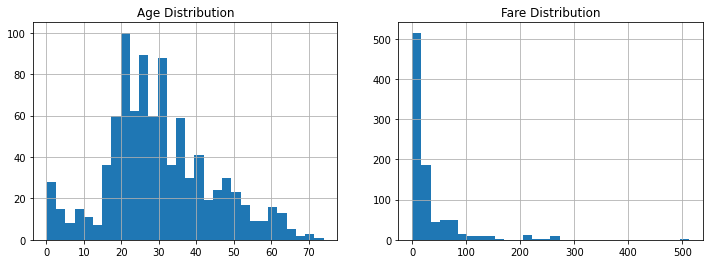

In [7]:
# lets xplore the distribution of age and fare in the original data

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
X_train['age'].hist(bins = 30)
plt.title('Age Distribution')

plt.subplot(1,2,2)
X_train['fare'].hist(bins = 30)
plt.title('Fare Distribution')
plt.show()

## Equal frequency discretisation with pandas and NumPy

The interval limits are the quantile limits. We can find those out with pandas qcut.

In [8]:
# let's use pandas qcut (quantile cut) and 
# we want 10 bins.

# retbins = True indicates that I want to capture the limits
# of each interval (so I can then use them to cut the test set)

Age_disccretised, intervals = pd.qcut(
    X_train['age'], 10, labels=None, retbins=True, precision=3, duplicates='raise')

pd.concat([Age_disccretised, X_train['age']], axis=1).head(10)

,age,age
501,"(0.166, 16.0]",13.0
588,"(0.166, 16.0]",4.0
402,"(28.0, 31.0]",30.0
1193,"(36.0, 42.0]",40.5
686,"(20.0, 22.0]",22.0
971,"(36.0, 42.0]",39.0
117,"(28.0, 31.0]",30.0
540,"(0.166, 16.0]",2.0
294,"(42.0, 50.0]",49.0
261,"(31.0, 36.0]",35.0


We can see in the above output how by discretising using quantiles, we placed each Age observation within one interval. For example, age 30 was placed in the 28-31 interval, whereas age 49 was placed into the 42-50 interval. 

Note how the interval widths are different.

We can visualise the interval cut points below:

In [9]:
intervals

array([ 0.1667, 16.    , 20.    , 22.    , 25.    , 28.    , 31.    ,
       36.    , 42.    , 50.    , 74.    ])

And because we generated the bins using the quantile cut method, we should have roughly the same amount of observations per bin. See below.

In [10]:
# roughly the same number of passengers per interval

Age_disccretised.value_counts()

(0.166, 16.0]    106
(31.0, 36.0]     106
(16.0, 20.0]      92
(22.0, 25.0]      92
(25.0, 28.0]      92
(28.0, 31.0]      90
(42.0, 50.0]      90
(36.0, 42.0]      85
(20.0, 22.0]      82
(50.0, 74.0]      81
Name: age, dtype: int64

In [11]:
# we can also add labels instead of having the interval boundaries, to the bins, as follows:

labels = ['Q'+str(i) for i in range(1,11)]
labels

['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10']

In [12]:
Age_disccretised, intervals = pd.qcut(X_train['age'], 10, labels=labels,
                                      retbins=True,
                                      precision=3, duplicates='raise')

Age_disccretised.head()

501     Q1
588     Q1
402     Q6
1193    Q8
686     Q3
Name: age, dtype: category
Categories (10, object): ['Q1' < 'Q2' < 'Q3' < 'Q4' ... 'Q7' < 'Q8' < 'Q9' < 'Q10']

In [13]:
# to apply the intervals to the test set, we need to extend
# the limits of the outer bins to -inf and +inf, so that if
# in the test set, there are smaller or bigger values than the 
# minimum or maximum values in the train set, they can be 
# accomodated in the outer intervals. 
# Otherwise, they will be replaced by NaN.

# Prepend/Append infinities to accommodate outliers
intervals[0] = float("-inf")
intervals[len(intervals) - 1] = float("inf")

intervals

array([-inf,  16.,  20.,  22.,  25.,  28.,  31.,  36.,  42.,  50.,  inf])

In [14]:
# to transform the test set:
# we use pandas cut method (instead of qcut) and
# pass the quantile edges calculated in the training set

X_test['Age_disc_label'] = pd.cut(x = X_test['age'], bins=intervals, labels=labels)
X_test['Age_disc'] = pd.cut(x = X_test['age'], bins=intervals)

X_test.head(10)

,age,fare,Age_disc_label,Age_disc
1139,38.0,7.8958,Q8,"(36.0, 42.0]"
533,21.0,21.0000,Q3,"(20.0, 22.0]"
459,42.0,27.0000,Q8,"(36.0, 42.0]"
1150,35.0,14.5000,Q7,"(31.0, 36.0]"
393,25.0,31.5000,Q4,"(22.0, 25.0]"
1189,4.0,16.7000,Q1,"(-inf, 16.0]"
5,48.0,26.5500,Q9,"(42.0, 50.0]"
231,52.0,30.5000,Q10,"(50.0, inf]"
330,57.0,13.0000,Q10,"(50.0, inf]"
887,9.0,8.1125,Q1,"(-inf, 16.0]"


In [15]:
X_test['Age_disc_label'].isnull().sum()

0

<AxesSubplot:xlabel='Age_disc'>

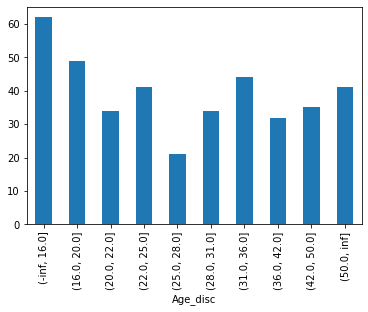

In [16]:
# let's check that we have equal frequency (equal number of observations per bin)
X_test.groupby('Age_disc')['age'].count().plot.bar()

We can see that the top intervals have less observations. This may happen with skewed distributions if we try to divide in a high number of intervals. To make the value spread  more homogeneous, we should discretise in less intervals.

## Equal frequency discretisation with Feature-Engine

In [22]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 2), (393, 2))

In [23]:
# replace NA in both  train and test sets

X_train['age'] = impute_na(data, 'age')
X_test['age'] = impute_na(data, 'age')

X_train['fare'] = impute_na(data, 'fare')
X_test['fare'] = impute_na(data, 'fare')

In [24]:
# with feature engine we can automate the process for many variables
# in one line of code

disc = EqualFrequencyDiscretiser(q=10, variables = ['age', 'fare'])

disc.fit(X_train)

EqualFrequencyDiscretiser(variables=['age', 'fare'])

In [25]:
# in the binner dict, we can see the limits of the intervals. Note
# that the intervals have different widths

disc.binner_dict_

{'age': [-inf, 15.0, 19.0, 22.0, 25.0, 28.0, 31.0, 36.0, 41.0, 50.0, inf],
 'fare': [-inf,
  7.55,
  7.7958,
  8.05,
  10.5,
  14.4542,
  21.075,
  26.55,
  40.125,
  79.025,
  inf]}

In [26]:
# transform train and text

train_t = disc.transform(X_train)
test_t = disc.transform(X_test)

In [27]:
train_t.head()

,age,fare
501,0,5
588,0,6
402,5,4
1193,5,1
686,2,1


Text(0, 0.5, 'Number of observations per bin')

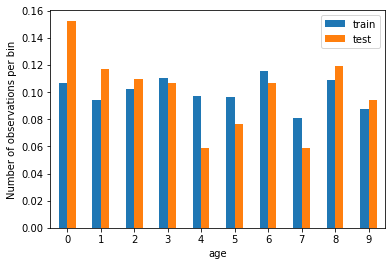

In [28]:
# and now let's explore the number of observations per bucket

t1 = train_t.groupby(['age'])['age'].count() / len(train_t)
t2 = test_t.groupby(['age'])['age'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

Text(0, 0.5, 'Number of observations per bin')

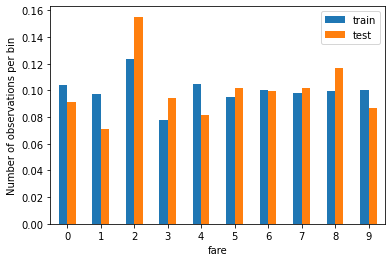

In [29]:
t1 = train_t.groupby(['fare'])['fare'].count() / len(train_t)
t2 = test_t.groupby(['fare'])['fare'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

Note how equal frequency discretisation obtains a better value spread across the different intervals.

## Equal frequency discretisation with Scikit-learn

In [30]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 2), (393, 2))

In [31]:
# replace NA in both  train and test sets

X_train['age'] = impute_na(data, 'age')
X_test['age'] = impute_na(data, 'age')

X_train['fare'] = impute_na(data, 'fare')
X_test['fare'] = impute_na(data, 'fare')

In [32]:
disc = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile') # quantile for being equal frequency
disc.fit(X_train[['age', 'fare']])

KBinsDiscretizer(encode='ordinal', n_bins=8)

In [33]:
disc.bin_edges_

array([array([ 0.1667, 17.    , 21.    , 24.    , 28.    , 32.    , 38.125 ,
              47.625 , 80.    ])                                            ,
       array([  0.    ,   7.75  ,   7.8958,  10.4625,  14.4542,  24.15  ,
               31.275 ,  69.55  , 512.3292])                             ],
      dtype=object)

In [34]:
train_t = disc.transform(X_train[['age', 'fare']])

train_t = pd.DataFrame(train_t, columns = ['age', 'fare'])

train_t.head()

,age,fare
0,0.0,4.0
1,0.0,4.0
2,4.0,3.0
3,4.0,0.0
4,2.0,0.0


In [35]:
test_t = disc.transform(X_test[['age', 'fare']])

# since sklearn returns numpy array
test_t = pd.DataFrame(test_t, columns = ['age', 'fare'])

Text(0, 0.5, 'Number of observations per bin')

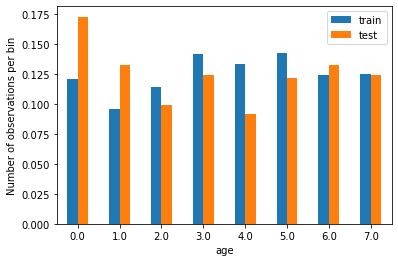

In [36]:
t1 = train_t.groupby(['age'])['age'].count() / len(train_t)
t2 = test_t.groupby(['age'])['age'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

Text(0, 0.5, 'Number of observations per bin')

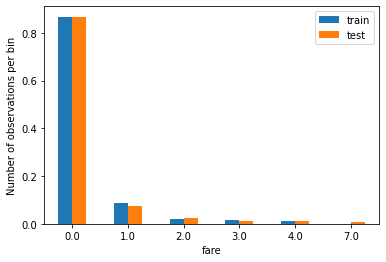

In [55]:
t1 = train_t.groupby(['fare'])['fare'].count() / len(train_t)
t2 = test_t.groupby(['fare'])['fare'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')